In [2]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path

"""
!!! Change show_in_window to True if You prefer to use cv2.imshow(..) instesd of matplotlib.pyplot.imshow(..)
"""
show_in_window = False

In [13]:
def display_image(window_name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    global show_in_window

    if(show_in_window):
        cv.imshow(window_name, img)
        cv.waitKey(0)
        cv.destroyAllWindows()

    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()

## Task 1 Fourier Transform
In this task, we will show a useful property of the Fourier
Transform, which is the convolution property. It tells us that convolution in the
spatial domain corresponds to multiplication in the frequency domain. The input
image that you will be operating on is orange.jpeg and celeb.jpeg.

* Load the two images orange.jpeg and celeb.jpeg. Remember to convert to
grayscale.

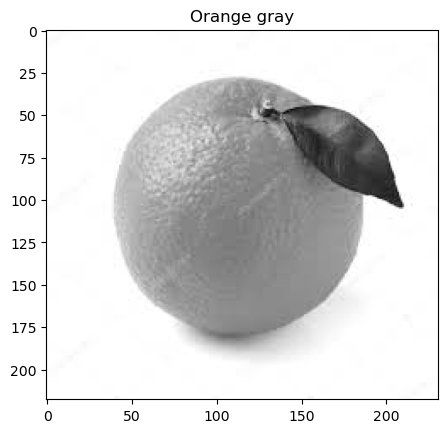

Orange shape: (218, 231)


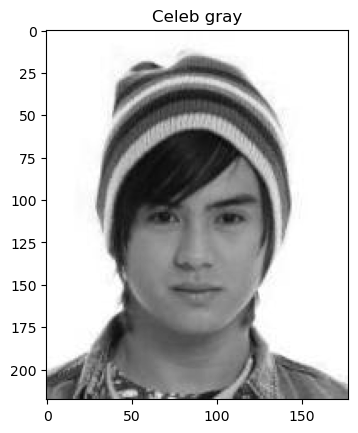

Celeb shape: (218, 178)


In [14]:
# set images pathes
orange_path = '../data/orange.jpeg'
celeb_path = '../data/celeb.jpeg'
# read imgs
img_orange = cv.imread(orange_path, cv.IMREAD_GRAYSCALE)
img_celeb = cv.imread(celeb_path, cv.IMREAD_GRAYSCALE)

display_image('Orange gray', img_orange)
print(f"Orange shape: {img_orange.shape}")
display_image('Celeb gray', img_celeb)
print(f"Celeb shape: {img_celeb.shape}")

* Create a 7 × 7 Gaussian kernel with sigma=1.

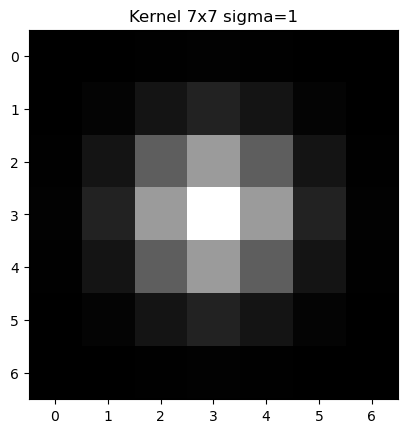

In [15]:
def get_kernel(sigma):
    kernel_size = 7
    # init 2D kernel filled with zeros
    kernel = np.zeros((kernel_size, kernel_size), dtype="float64")
    # iterate over 2 dimensions and compute a value for every pixel with gaussian distribution
    for i in range(-(kernel_size // 2), (kernel_size // 2) + 1):
        for j in range(-(kernel_size // 2), (kernel_size // 2) + 1):
            kernel[i + (kernel_size // 2), j + (kernel_size // 2)] = np.exp(-0.5 * (i * i + j * j) / (sigma * sigma))
    # return normalized kernel
    return kernel / kernel.sum()

kernel = get_kernel(1)

display_image('Kernel 7x7 sigma=1', kernel)

In [20]:
def blur_im_spatial(image, kernel):
    """
    Blurs the image using spatial filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    return cv.filter2D(image, -1, kernel)


* Blur the images by convolving the image with the Gaussian kernel directly in
the spatial domain. You may use the library function (cv2.filter2D).

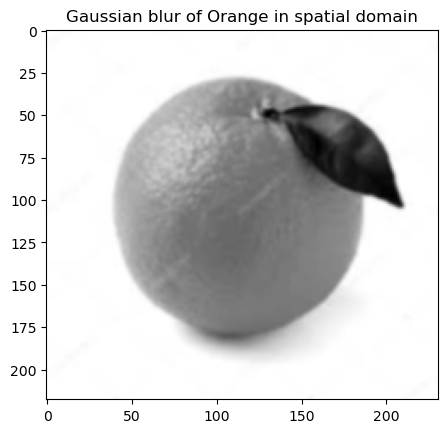

In [25]:
start = time.perf_counter()
blur_img_orange_spatial = blur_im_spatial(img_orange, kernel=kernel)
end = time.perf_counter()
orange_spatial_time = end - start
display_image('Gaussian blur of Orange in spatial domain', blur_img_orange_spatial)

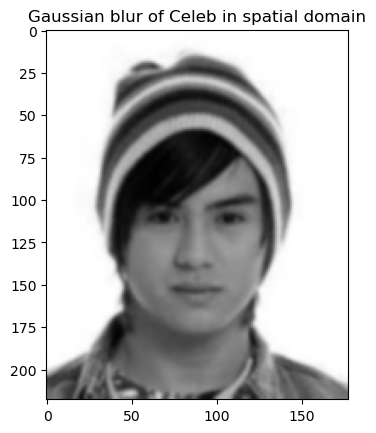

In [26]:
start = time.perf_counter()
blur_img_celeb_spatial = blur_im_spatial(img_celeb, kernel=kernel)
end = time.perf_counter()
celeb_spatial_time = end - start
display_image('Gaussian blur of Celeb in spatial domain', blur_img_celeb_spatial)

* Now we are going to blur the images in the frequency domain using Fourier
Transform. We multiply the kernel function and the frequency image instead
of applying convolution. To get the final result, we transform back to the image
space. You may use functions included in the package numpy.fft to apply the
transform and its inverse.

In [34]:
# blur the image in the frequency domain
def blur_im_freq(image, kernel):
    """
    Blurs the image using frequency filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    # compute fft of image
    fft_image = np.fft.fft2(image)
    # compute fft of kernel with the same shape as image
    fft_kernel = np.fft.fft2(kernel, s=image.shape)
    # compute convolution in frequency domain
    fft_result = fft_image * fft_kernel
    # compute inverse fft
    result = np.fft.ifft2(fft_result)
    # return real part of the result
    return np.abs(result).astype(np.uint8)

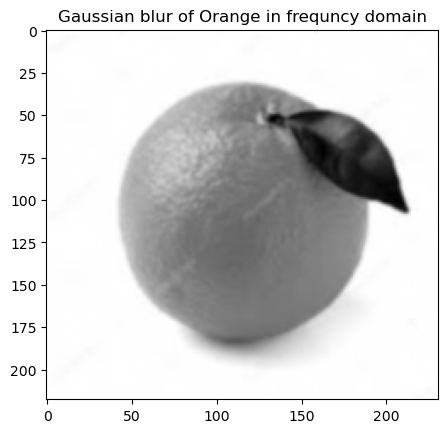

In [31]:
start = time.perf_counter()
blur_img_orange_frequency = blur_im_freq(img_orange, kernel=kernel)
end = time.perf_counter()
orange_freq_time = end - start
display_image('Gaussian blur of Orange in frequncy domain', blur_img_orange_frequency)

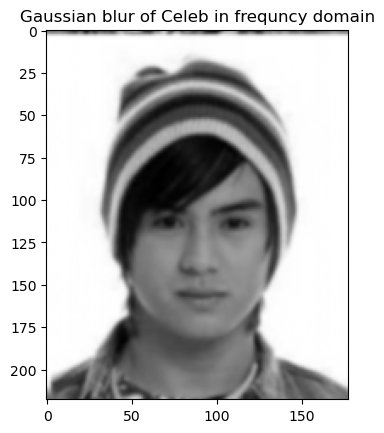

In [32]:
start = time.perf_counter()
blur_img_celeb_frequency = blur_im_freq(img_celeb, kernel=kernel)
end = time.perf_counter()
celeb_freq_time = end - start
display_image('Gaussian blur of Celeb in frequncy domain', blur_img_celeb_frequency)

* Visualise the results for both images and report the mean absolute difference
between the two blurring methods and the time taken by each of them.

In [36]:
def difference_between(im_1,im_2):
    """
    Computes the absolute difference and
    max absolute difference between two images.
    """
    diff = np.abs(np.subtract(im_1, im_2))
    max_diff = np.max(diff)
    return diff, max_diff

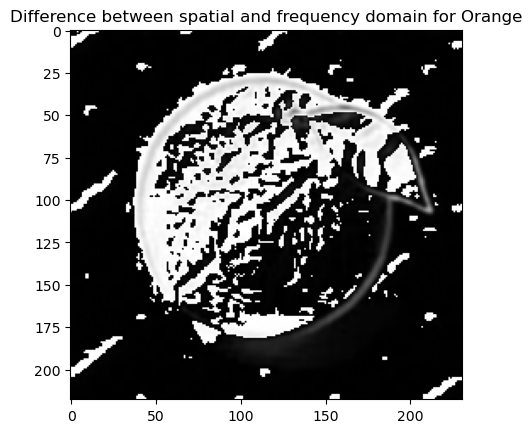

Orange max difference: 255


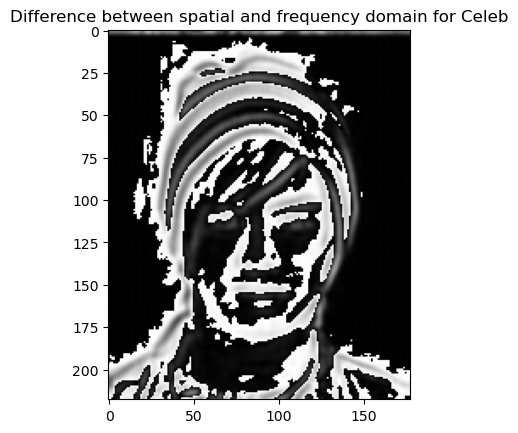

Celeb max difference: 255
Orange spatial time: 0.0009294999999838183
Orange frequency time: 0.012459499999749823
Celeb spatial time: 0.0006067000003895373
Celeb frequency time: 0.012485799999922165


In [39]:
orange_diff, orange_max_diff = difference_between(blur_img_orange_spatial, blur_img_orange_frequency)
celeb_diff, celeb_max_diff = difference_between(blur_img_celeb_spatial, blur_img_celeb_frequency)

display_image('Difference between spatial and frequency domain for Orange', orange_diff)
print(f"Orange max difference: {orange_max_diff}")
display_image('Difference between spatial and frequency domain for Celeb', celeb_diff)
print(f"Celeb max difference: {celeb_max_diff}")

print(f"Orange spatial time: {orange_spatial_time}")
print(f"Orange frequency time: {orange_freq_time}")

print(f"Celeb spatial time: {celeb_spatial_time}")
print(f"Celeb frequency time: {celeb_freq_time}")
